# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)
#print(filtered_data[filtered_data['Score']==1].count())
#print(filtered_data[filtered_data['Score']==0].count())

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [11]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [12]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [15]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:33<00:00, 1374.24it/s]


In [19]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

## [3.2] Preprocessing Review Summary

In [20]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:22<00:00, 2024.30it/s]


In [21]:
preprocessed_summary[1500]

'gym rat bargain'

# [4] Featurization

## [4.1] BAG OF WORDS

In [22]:
#BoW
def bow(data):
    count_vect = CountVectorizer() #in scikit-learn
    count_vect.fit_transform(data)
    return count_vect


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [39]:
def tf_idf(data):
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    tf_idf_vect.fit(data)
    return tf_idf_vect


### [4.4] W2V

In [51]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
def create_w2v_model(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    return w2v_model

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [57]:
# average Word2Vec
def avgw2v(data,w2v_model,w2v_words):
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(data): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
        

#### [4.4.1.2] TFIDF weighted W2v

In [73]:
# TF-IDF weighted Word2Vec
def tfidfw2v(data,w2v_model,w2v_words,tfidf_model):
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(data): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

### Simple cross Validation

In [81]:
def cross_validation(x_tr_vect,y_tr,x_cv_vect,y_cv):
    for i in range(1,30,2):
        # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(algorithm='brute',n_neighbors=i)

        # fitting the model on crossvalidation train
        knn.fit(x_tr_vect, y_tr)

        # predict the response on the crossvalidation train
        pred = knn.predict(x_cv_vect)

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
        print('\nCV accuracy for k = %d is %d%%' % (i, acc))


### K-fold Cross Validation

In [86]:
def k_fold_cross_validation(x_tr_vect,y_tr):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_tr_vect, y_tr, cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))

# [5] KNN Models

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
x = preprocessed_reviews
y = final['Score'].tolist()
# split the data set into train and test
x_1, x_test, y_1, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
x_tr, x_cv, y_tr, y_cv = model_selection.train_test_split(x_1, y_1, test_size=0.3)

In [25]:
print(len(x_tr),len(x_test))
print(len(y_tr),len(y_test))
print(len(x_cv),len(x_cv))

22574 13822
22574 13822
9675 9675


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

### [5.1.1.1] Converting text to BOW

In [26]:

count_vect = bow(x_tr)
x_tr_bow = count_vect.transform(x_tr)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)


In [27]:
print(x_cv_bow.get_shape())
print(x_tr_bow.get_shape())

(9675, 28174)
(22574, 28174)


### [5.1.1.2] Finding K value

#### Simple cross Validation

In [28]:
cross_valiation(x_tr_bow,y_tr,x_cv_bow,y_cv)


CV accuracy for k = 1 is 78%

CV accuracy for k = 3 is 82%

CV accuracy for k = 5 is 82%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%


#### 10 fold cross validation


The optimal number of neighbors is 47.


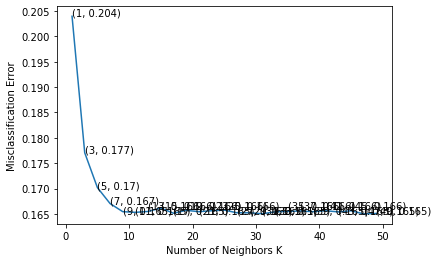

the misclassification error for each k value is :  [0.204 0.177 0.17  0.167 0.165 0.165 0.166 0.166 0.165 0.166 0.165 0.166
 0.166 0.165 0.165 0.165 0.165 0.166 0.166 0.165 0.166 0.165 0.166 0.165
 0.165]


In [35]:
k_fold_cross_validation(x_tr_bow,y_tr)

### [5.1.1.3] Final testing accuracy on testing data using k = 47

In [36]:
knn = KNeighborsClassifier(algorithm='brute',n_neighbors = 47)
knn.fit(x_tr_bow,y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')

In [37]:
pred = knn.predict(x_test_bow)

In [38]:
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

### [5.1.2.1] Converting text to TFIDF

In [40]:
tf_idf_vect = tf_idf(x_tr)
x_tr_tfidf = tf_idf_vect.transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

In [41]:
print(x_tr_tfidf.get_shape())

(22574, 13489)


### [5.1.2.2] Finding K value

#### Simple cross validation

In [42]:
cross_validation(x_tr_tfidf,y_tr,x_cv_tfidf,y_cv)


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 83%

CV accuracy for k = 5 is 83%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%


#### 10 fold cross validation


The optimal number of neighbors is 1.


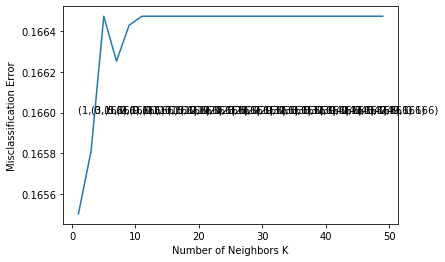

the misclassification error for each k value is :  [0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166
 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166
 0.166]


In [43]:
k_fold_cross_validation(x_tr_tfidf,y_tr)

### [5.1.1.3] Final testing accuracy on testing data using k = 1

In [45]:
knn = KNeighborsClassifier(algorithm='brute',n_neighbors=1)
knn.fit(x_tr_tfidf,y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [46]:
pred_tfidf_brute = knn.predict(x_test_tfidf)


In [47]:
acc = accuracy_score(y_test, pred_tfidf_brute, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

### [5.1.3.1] Converting text to AVG W2V

In [54]:
w2v_model = create_w2v_model(x_tr)

[('awesome', 0.8721205592155457), ('fantastic', 0.8157721161842346), ('excellent', 0.805469810962677), ('amazing', 0.7937829494476318), ('good', 0.7924492955207825), ('wonderful', 0.7836591601371765), ('perfect', 0.7223864793777466), ('decent', 0.7085862159729004), ('delicious', 0.6949341893196106), ('satisfied', 0.6748478412628174)]
[('closest', 0.8183450698852539), ('ever', 0.8130404949188232), ('nastiest', 0.7951653003692627), ('best', 0.7442362308502197), ('awful', 0.7338231205940247), ('sf', 0.7337555289268494), ('greatest', 0.7307312488555908), ('ive', 0.7193170785903931), ('tasted', 0.7154567241668701), ('experienced', 0.7128145098686218)]


In [56]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9128
sample words  ['good', 'snack', 'every', 'peanut', 'butter', 'taste', 'little', 'overpowering', 'otherwise', 'light', 'amount', 'wafer', 'chocolate', 'could', 'use', 'something', 'else', 'like', 'caramel', 'using', 'treats', 'long', 'time', 'decades', 'find', 'accepted', 'almost', 'pets', 'dog', 'cat', 'ferret', 'reward', 'taking', 'meds', 'nicely', 'prefer', 'largest', 'size', 'tubs', 'economy', 'convenience', 'usually', 'not', 'available', 'pet', 'stores', 'thank', 'carrying', 'natural', 'licorice']


In [58]:
x_tr_avgw2v = avgw2v(x_tr,w2v_model,w2v_words)

100%|████████████████████████████████████████████████████████████████████████████| 22574/22574 [07:04<00:00, 53.17it/s]


In [62]:
x_test_avgw2v = avgw2v(x_test,w2v_model,w2v_words)

100%|████████████████████████████████████████████████████████████████████████████| 13822/13822 [04:20<00:00, 53.02it/s]


In [63]:
x_cv_avgw2v = avgw2v(x_cv,w2v_model,w2v_words)

100%|██████████████████████████████████████████████████████████████████████████████| 9675/9675 [03:07<00:00, 51.70it/s]


In [61]:
len(x_tr_avgw2v)

22574

### [5.1.3.2] Finding K value

#### Simple cross validation

In [64]:
cross_validation(x_tr_avgw2v,y_tr,x_cv_avgw2v,y_cv)


CV accuracy for k = 1 is 73%

CV accuracy for k = 3 is 79%

CV accuracy for k = 5 is 81%

CV accuracy for k = 7 is 82%

CV accuracy for k = 9 is 82%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%


#### 10 fold cross validation


The optimal number of neighbors is 35.


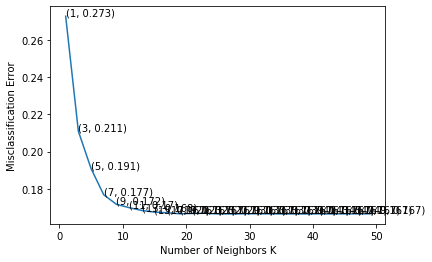

the misclassification error for each k value is :  [0.273 0.211 0.191 0.177 0.172 0.17  0.168 0.167 0.167 0.167 0.167 0.167
 0.167 0.167 0.167 0.167 0.167 0.167 0.167 0.167 0.167 0.167 0.167 0.167
 0.167]


In [65]:
k_fold_cross_validation(x_tr_avgw2v,y_tr)

### [5.1.3.3] Final testing accuracy on testing data using k = 35

In [66]:
knn = KNeighborsClassifier(algorithm='brute',n_neighbors=35)
knn.fit(x_tr_avgw2v,y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [68]:
pred_avgw2v_brute = knn.predict(x_test_avgw2v)

In [69]:
acc = accuracy_score(y_test, pred_avgw2v_brute, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

### [5.1.4.1] Converting text to TFIDF W2V

In [71]:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(x_tr)

In [74]:
x_tr_tfidfw2v = tfidfw2v(x_tr,w2v_model,w2v_words,tfidf_model)

100%|████████████████████████████████████████████████████████████████████████████| 22574/22574 [21:21<00:00, 17.61it/s]


In [75]:
x_test_tfidfw2v = tfidfw2v(x_test,w2v_model,w2v_words,tfidf_model)

100%|████████████████████████████████████████████████████████████████████████████| 13822/13822 [12:53<00:00, 17.86it/s]


In [76]:
x_cv_tfidfw2v = tfidfw2v(x_cv,w2v_model,w2v_words,tfidf_model)

100%|██████████████████████████████████████████████████████████████████████████████| 9675/9675 [10:11<00:00, 15.81it/s]


In [77]:
len(x_tr_tfidfw2v)

22574

### Finding k value

#### Simple cross validation

In [83]:
cross_validation(x_tr_tfidfw2v,y_tr,x_cv_tfidfw2v,y_cv)


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 83%

CV accuracy for k = 5 is 83%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%


#### 10 fold cross validation


The optimal number of neighbors is 1.


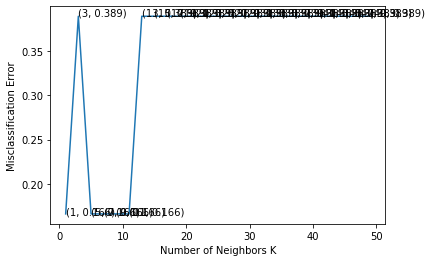

the misclassification error for each k value is :  [0.166 0.389 0.166 0.166 0.166 0.166 0.389 0.389 0.389 0.389 0.389 0.389
 0.389 0.389 0.389 0.389 0.389 0.389 0.389 0.389 0.389 0.389 0.389 0.389
 0.389]


In [87]:
k_fold_cross_validation(x_tr_tfidfw2v,y_tr)

### [5.1.3.3] Final testing accuracy on testing data using 

In [91]:
knn = KNeighborsClassifier(algorithm='brute',n_neighbors=1)
knn.fit(x_tr_tfidfw2v,y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [92]:
pred_tfidfw2v_brute = knn.predict(x_test_tfidfw2v)

In [93]:
acc = accuracy_score(y_test, pred_tfidfw2v_brute, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [94]:
knn = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=47)
knn.fit(x_tr_bow,y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')

In [95]:
pred_bow_kdtree = knn.predict(x_test_bow)

In [96]:
acc = accuracy_score(y_test, pred_bow_kdtree, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [97]:
knn = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=1)
knn.fit(x_tr_tfidf,y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [98]:
pred_tfidf_kdtree = knn.predict(x_test_tfidf)

In [99]:
acc = accuracy_score(y_test, pred_tfidf_kdtree, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [100]:
knn = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=35)
knn.fit(x_tr_avgw2v,y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [101]:
pred_avgw2v_kdtree = knn.predict(x_test_avgw2v)

In [102]:
acc = accuracy_score(y_test, pred_avgw2v_kdtree, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [103]:
knn = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=1)
knn.fit(x_tr_tfidfw2v,y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [105]:
pred_tfidfw2v_kdtree = knn.predict(x_test_tfidfw2v)

In [106]:
acc = accuracy_score(y_test, pred_tfidfw2v_kdtree, normalize=True) * float(100)
print('\nTest accuracy of KNN brute force is %d%%' % (acc))


Test accuracy of KNN brute force is 83%


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library